<a href="https://colab.research.google.com/github/wilmi94/MasterThesis-AE/blob/main/notebooks/sdo_ConvLSTM_exp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SDO/AIA  full-disk Prediction Model

> This notebook is part of the Master Thesis *Predicting Coronal Mass Ejections using Machine Learning methods* by Wilmar Ender, FH Wiener Neustadt, 2023.

This notebook is considered the final model of the thesis and therefore includes the parts Data Preparation (section 4.4 in thesis), Model (section 4.5 in thesis) and Evaluation (section 4.6 in thesis).

**Objective:** \\
* This notebook aims to perform the prediction of CMEs based on a given sequence of full-disk images from the SDO/AIA dataset.
* apply a ConvLSTM model on the dataset and
* Evaluate the ''reliability'' of such a pure black-box approach in terms of CME prediction.
**Solar event list:** \\
*Liu et al. 2020, Predicting Coronal Mass Ejections Using SDO/HMI Vector Magnetic Data Products and Recurrent Neural Networks*

**Dataset:** \\
*Ahmadzadeh et al. 2019, A Curated Image Parameter Data Set from the Solar Dynamics Observatory Mission*. \\
Accessed via *sdo-cli* (https://github.com/i4Ds/sdo-cli)

*Predicting Solar Flares Using a Long Short-term Memory Network. Liu, H., Liu, C., Wang, J. T. L., Wang, H., ApJ., 877:121, 2019.*


...

## Setting up the Notebook

In [1]:
# %%capture
# pip install -U sdo-cli

In [2]:
import pandas as pd
import csv
import sys
import numpy as np
import cv2
import os
import shutil
from datetime import datetime
import subprocess
from PIL import Image
from tqdm import tqdm

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from google.colab import files
from google.colab import drive

from keras.utils import plot_model
import tensorflow as tf

from sklearn.utils import class_weight
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, LSTM,ConvLSTM2D, GlobalAveragePooling2D, Dense, TimeDistributed, MaxPooling2D, Flatten, SpatialDropout2D, Dropout, BatchNormalization, Conv1D
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import LearningRateScheduler

In [3]:
# drive.flush_and_unmount()

In [4]:
# mount Google drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [5]:
# Change present working directory
%cd /content/drive/MyDrive/Academia/MSc. Aerospace Engineering - FH Wiener Neustadt/4. Master Thesis/03-Work/

/content/drive/MyDrive/Academia/MSc. Aerospace Engineering - FH Wiener Neustadt/4. Master Thesis/03-Work


In [6]:
# check content
!ls -a

 00_Dataset		   02_sdo_binclass   04_Tests				        .sdo-cli
 01_sdo_data_exploration   03_sdo_ConvLSTM  'Master Thesis-ML-Project-Checklist.gdoc'


## Helper Functions
Define helper-functions to either speed up the calculation process of for better automation.

In [7]:
def lr_schedule(epoch, learning_rate):
  """
  Learning rate schedule function.

  Args:
      epoch (int): The current epoch number.
      learning_rate (float): The current learning rate.

  Returns:
      float: Updated learning rate based on the specified schedule.
          - If epoch is less than 10, returns the current learning rate.
          - If epoch is greater than or equal to 10, returns the current
            learning rate multiplied by 0.1 (reduced by a factor of 0.1).
  """
  if epoch < 5:
      return learning_rate
  else:
      return learning_rate * 0.1

In [8]:
def classify_and_copy_images(source_dir, positive_dir, negative_dir, event_dataframe):
    """
    Classify and copy images based on timestamps and labels from a DataFrame.

    Parameters:
    - source_dir: Path to the source directory containing images.
    - positive_dir: Path to the directory where positive images will be copied.
    - negative_dir: Path to the directory where negative images will be copied.
    - event_dataframe: DataFrame containing 'Timestamp' and 'Label' columns.

    Returns:
    - copied_files: List of successfully copied filenames.
    - failed_files: List of filenames that couldn't be copied.
    """

    # Ensure destination directories exist
    os.makedirs(positive_dir, exist_ok=True)
    os.makedirs(negative_dir, exist_ok=True)

    copied_files = []
    failed_files = []

    for index, row in event_dataframe.iterrows():
        timestamp_str = row['Timestamp']
        label = row['Label']
        image_filename = timestamp_str + '.jpeg'

        source_path = os.path.join(source_dir, image_filename)

        if os.path.exists(source_path):
            destination_dir = positive_dir if label == 'P' else negative_dir
            destination_path = os.path.join(destination_dir, image_filename)

            try:
                shutil.copy(source_path, destination_path)
                copied_files.append(image_filename)
            except Exception as e:
                print(f"Error copying '{image_filename}': {str(e)}")
                failed_files.append(image_filename)
        else:
            print(f"Image '{image_filename}' not found in the source directory.")

    return copied_files, failed_files

In [9]:
def display_image_series(directory_path, start_image_index, end_image_index):
    # Get a list of image files in the directory
    image_files = sorted([f for f in os.listdir(directory_path) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.gif'))])

    # Ensure start and end indices are within bounds
    start_image_index = max(0, start_image_index)
    end_image_index = min(end_image_index, len(image_files) - 1)

    # Create a figure with subplots
    plt.figure(figsize=(20, 10))
    num_images = end_image_index - start_image_index + 1
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))

    for i in range(start_image_index, end_image_index + 1):
        img_path = os.path.join(directory_path, image_files[i])
        img = mpimg.imread(img_path)

        # Extract timestamp from the filename
        timestamp_str = os.path.splitext(image_files[i])[0]
        timestamp = datetime.strptime(timestamp_str, "%Y-%m-%dT%H%M%S")

        # Display the image
        axes[i - start_image_index].imshow(img)
        axes[i - start_image_index].axis('off')

        # Display the customized title based on the timestamp
        title = timestamp.strftime("%Y-%m-%d %H:%M:%S")
        axes[i - start_image_index].set_title(title, fontsize=12)

    plt.subplots_adjust(wspace=0.1)  # Adjust space between subplots
    plt.show()

In [10]:
def rename_files_in_folder(folder_path):
  """
    Rename files in the specified directory by removing the "__171" substring from their names.

    Parameters:
    - folder_path (str): The path to the directory containing the files to be renamed.

    If the provided path is not a directory, a message will be printed, and no renaming will occur.

    Example:
    >>> rename_files_in_folder("/path/to/directory")
    Renamed: example__171.txt to example.txt
    Renamed: image__171.png to image.png
    ...
    """

    # Check if the provided path is a directory
  if not os.path.isdir(folder_path):
      print(f"{folder_path} is not a directory.")
      return

  # Iterate through files in the directory
  for filename in os.listdir(folder_path):
      old_file_path = os.path.join(folder_path, filename)

      # Check if it's a file (not a directory)
      if os.path.isfile(old_file_path):
          # Split the filename and extension
          base_name, file_extension = os.path.splitext(filename)

          # Check if the filename contains "__171"
          if "__171" in base_name:
              # Remove the "__171" part
              new_base_name = base_name.replace("__171", "")
              new_filename = f"{new_base_name}{file_extension}"
              new_file_path = os.path.join(folder_path, new_filename)

              # Rename the file
              os.rename(old_file_path, new_file_path)
              print(f"Renamed: {filename} to {new_filename}")


In [11]:
def compare_filenames_with_dataframe(directory, dataframe):
  """
    Compare filenames in a directory with timestamps in a DataFrame.

    Parameters:
    - directory (str): The path to the directory containing files to be compared.
    - dataframe (pd.DataFrame): A DataFrame containing timestamps to be compared with filenames.

    Returns:
    - statistics (dict): A dictionary with the following statistics:
        - 'Total Directory Files': Total files in the directory.
        - 'Total DataFrame Names': Total timestamps in the DataFrame.
        - 'Common Files': Number of files with corresponding timestamps.
        - 'Missing Files': Number of timestamps without corresponding files.
        - 'Extra Files': Number of files without corresponding timestamps.
    - df_missing (pd.DataFrame): A DataFrame containing missing timestamps in a more readable format.

    This function compares filenames in the specified directory with timestamps in the given DataFrame.
    It calculates and returns statistics on common, missing, and extra files, along with a DataFrame of missing timestamps.
    """

  file_end = '.jpeg'
  # Get list of filenames from the directory
  directory_filenames = [filename for filename in os.listdir(directory) if filename.endswith(file_end)]

  # Get list of names from the DataFrame
  df_check = dataframe.copy()
  df_check['Timestamp'] = pd.to_datetime(df_check['Timestamp']).dt.strftime('%Y-%m-%dT%H%M%S.jpeg') # Warning! wavelength is now hard coded

  dataframe_names = df_check['Timestamp'].tolist()  # the name of the image should correspond to the timestamp

  # Compare filenames
  common_filenames = set(directory_filenames) & set(dataframe_names)
  missing_filenames = set(dataframe_names) - set(directory_filenames)
  extra_filenames = set(directory_filenames) - set(dataframe_names)

  df_missing = pd.DataFrame (data = missing_filenames,  columns=['Timestamp'])
  df_missing['Timestamp'] = df_missing['Timestamp'].str.replace(r'.jpeg', '', regex=True)
  df_missing['Timestamp'] = pd.to_datetime(df_missing['Timestamp']).dt.strftime('%Y-%m-%dT%H:%M:%S')

  # Calculate statistics
  total_directory_files = len(directory_filenames)
  total_dataframe_names = len(dataframe_names)
  total_common_files = len(common_filenames)
  total_missing_files = len(missing_filenames)
  total_extra_files = len(extra_filenames)
  print('Total Directory Files: ', total_directory_files)
  print('Total DataFrame Names: ', total_dataframe_names)
  print('Common Files: ', total_common_files)
  print('Missing Files: ', total_missing_files)
  print('Extra Files: ', total_extra_files)

  statistics = {
      'Total Directory Files': total_directory_files,
      'Total DataFrame Names': total_dataframe_names,
      'Common Files': total_common_files,
      'Missing Files': total_missing_files,
      'Extra Files': total_extra_files,
      #'Common File Names': common_filenames,
      'Missing File Names': missing_filenames,
      'Extra File Names': extra_filenames
  }

  return statistics, df_missing

In [12]:
def create_csv_from_directory(dataframe, directory_path, output_csv_path):
    # Initialize an empty list to store timestamp-label pairs
    timestamp_label_pairs = []

    # Use os.walk to recursively traverse the directory and its subfolders
    for root, _, files in os.walk(directory_path):
        for file_name in files:
            # Extract the timestamp from the file name
            parts = file_name.split('T')
            if len(parts) == 2:
                file_timestamp_str = parts[0] + 'T' + parts[1].split('.')[0]
            else:
                # Handle invalid file name format
                continue

            try:
                # Convert the file timestamp string to a datetime object
                file_timestamp = datetime.strptime(file_timestamp_str, '%Y-%m-%dT%H%M%S')
            except ValueError:
                # Handle invalid timestamp format
                continue

            # Find the corresponding row in the DataFrame based on the timestamp
            matching_row = dataframe[dataframe['Timestamp'] == file_timestamp.strftime('%Y-%m-%dT%H:%M:%S')]

            if not matching_row.empty:
                # Get the label from the matching row
                label = matching_row.iloc[0]['Label']

                # Append the timestamp-label pair to the list
                timestamp_label_pairs.append((file_timestamp_str, label))

    # Create a new DataFrame from the list of timestamp-label pairs
    result_df = pd.DataFrame(timestamp_label_pairs, columns=['Timestamp', 'Label'])
    result_df = result_df.sort_values(by='Timestamp', ascending = True)
    # Save the DataFrame to a CSV file
    result_df.to_csv(output_csv_path, index=False)



In [13]:
def copy_last_n_images(source_directory, destination_directory, n=None):
    # Get a list of files in the source directory
    files = sorted(os.listdir(source_directory))

    # Ensure the destination directory exists
    os.makedirs(destination_directory, exist_ok=True)

    # Copy the last n files, or all files if n is None
    files_to_copy = files[-n:] if n is not None else files

    for file_name in files_to_copy:
        source_path = os.path.join(source_directory, file_name)
        destination_path = os.path.join(destination_directory, file_name)
        shutil.copy2(source_path, destination_path)

In [14]:
def copy_images_between_indices(source_directory, destination_directory, start_index, end_index):
    # Get a list of files in the source directory
    files = sorted(os.listdir(source_directory))

    # Ensure the destination directory exists
    os.makedirs(destination_directory, exist_ok=True)

    # Ensure start_index and end_index are within bounds
    start_index = max(0, start_index)
    end_index = min(end_index, len(files) - 1)

    # Copy the files between start_index and end_index (inclusive)
    files_to_copy = files[start_index:end_index + 1]

    for file_name in files_to_copy:
        source_path = os.path.join(source_directory, file_name)
        destination_path = os.path.join(destination_directory, file_name)
        shutil.copy2(source_path, destination_path)


In [15]:
def resize_images(source_dir, target_dir):
  # Function to resize images
    with tqdm(total=len(os.listdir(source_dir)), desc=f"Resizing {source_dir} images") as pbar:
        for filename in os.listdir(source_dir):
            if filename.endswith('.jpeg'):
                source_path = os.path.join(source_dir, filename)
                target_path = os.path.join(target_dir, filename)
                # Open the image and resize it
                img = Image.open(source_path)
                img = img.resize((new_width, new_height), Image.ANTIALIAS)
                img.save(target_path)
                pbar.update(1)

In [16]:
def normalize_images(source_dir, target_dir, dataset_type):
  # Function to normalize images from 0 to 255 with a progress bar (no print messages)
    images = os.listdir(source_dir)
    with tqdm(total=len(images), desc=f"Normalizing {dataset_type} images", unit="image", dynamic_ncols=True) as pbar:
        for filename in images:
            if filename.endswith('.jpeg'):
                source_path = os.path.join(source_dir, filename)
                target_path = os.path.join(target_dir, filename)

                # Load the image
                img = cv2.imread(source_path)

                # Normalize the image from 0 to 255
                normalized_img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX)

                # Save the normalized image
                cv2.imwrite(target_path, normalized_img)

                # Update progress bar
                pbar.update(1)

In [17]:
def classify_images(source_dir, positive_dir, negative_dir):
  # Function to classify and move images based on timestamps within event ranges training
    for filename in os.listdir(source_dir):
        if filename.endswith('.jpeg'):
            timestamp = filename[:-5]  # Extract timestamp from the filename (remove '.jpeg' extension)
            # Check if the timestamp is within any event range in the 'cme_events' DataFrame
            for _, event in df_cme_list.iterrows():
                if(event['CME']!="no"):
                  start_time = event['Start Time']  # Replace 'start_time' with the actual column name
                  end_time = event['End Time']  # Replace 'end_time' with the actual column name
                  if start_time <= timestamp <= end_time:
                      # Move to the positive folder
                      shutil.copy2(os.path.join(source_dir, filename), os.path.join(positive_dir, filename))
                      break  # Move to the next image
            else:
                # If the timestamp does not fall within any event range, move to the negative folder
                shutil.copy2(os.path.join(source_dir, filename), os.path.join(negative_dir, filename))

In [18]:
def classify_and_move_images(source_dir, positive_dir, negative_dir):
  # Function to classify and move images based on timestamps within event ranges training
    for filename in os.listdir(source_dir):
        if filename.endswith('.jpeg'):
            timestamp = filename[:-5]  # Extract timestamp from the filename (remove '.jpeg' extension)
            # Check if the timestamp is within any event range in the 'cme_events' DataFrame
            for _, event in df_cme_list.iterrows():
                if(event['CME']!="no"):
                  start_time = event['Start Time']  # Replace 'start_time' with the actual column name
                  end_time = event['End Time']  # Replace 'end_time' with the actual column name
                  if start_time <= timestamp <= end_time:
                      # Move to the positive folder
                      shutil.move(os.path.join(source_dir, filename), os.path.join(positive_dir, filename))
                      break  # Move to the next image
            else:
                # If the timestamp does not fall within any event range, move to the negative folder
                shutil.move(os.path.join(source_dir, filename), os.path.join(negative_dir, filename))

In [19]:
def delete_files_with_pattern(directory, pattern):
    # Recursively traverse the directory tree
    for root, _, files in os.walk(directory):
        for filename in files:
            if filename.endswith(pattern):
                file_path = os.path.join(root, filename)
                try:
                    os.remove(file_path)
                    print(f"Deleted: {file_path}")
                except Exception as e:
                    print(f"Failed to delete {file_path}: {str(e)}")

In [20]:
def load_and_preprocess_images_with_time(directory, image_size):
    images = []
    labels = []
    timestamps = []  # To store timestamps extracted from filenames

    for dirname in ['pos', 'neg']: #os.listdir(directory):
        for filename in os.listdir(os.path.join(directory, dirname)):
            if filename.endswith('.jpeg'):
                image_path = os.path.join(directory, dirname, filename)
                image = cv2.imread(image_path)
                image = cv2.resize(image, image_size)
                image = image.astype(np.float32) / 255.0  # Normalize pixel values to [0, 1]

                images.append(image)

                # Extract timestamp from the filename
                timestamp_str = filename[:-5]  # Remove '.jpeg' extension
                timestamp = datetime.strptime(timestamp_str, "%Y-%m-%dT%H%M%S")
                timestamps.append(timestamp)

                # Assuming that positive examples have filenames containing "pos" and negative examples "neg"
                if "pos" in dirname:
                    labels.append(1)  # Positive example
                elif "neg" in dirname:
                    labels.append(0)  # Negative example

    return np.array(images), np.array(labels), np.array(timestamps)

In [21]:
def display_image_sequences(X_test, y_test, num_sequences=5, num_series=5):
    for i in range(num_series):
        plt.figure(figsize=(20, 10))
        # Display each sequence
        for j in range(num_sequences):
            plt.subplot(1, num_sequences, j + 1)

            # Display the image with filename
            filename = f"Frame {j+1}"
            plt.imshow(X_test[i, j])
            plt.title(filename)
            plt.axis('off')

            # Display the label for each frame
            plt.text(0, -0.1, f"Label: {y_test[i]}", transform=plt.gca().transAxes)

        plt.show()

In [22]:
def has_duplicates(images):
    flattened_images = images.reshape(images.shape[0], -1)
    unique_hashes, unique_indices = np.unique(flattened_images, axis=0, return_index=True)
    duplicate_indices = np.setdiff1d(np.arange(flattened_images.shape[0]), unique_indices)
    return len(duplicate_indices) > 0, duplicate_indices

## Load Event-Lists
All lists are taken from *Liu et al. 2020*.

These are:
* a base/initail event list, which holds all the events and non-events
* a sampled training list
* a sampled testing list




**Base Event List**
The follwoing initial list holds all events and non-events from the study.

In [23]:
# load list with both (neg, pos) labels
df_cme_list = pd.read_csv(r'00_Dataset/event_lists/all_cme_events.csv', delimiter =';')

# convert time stamp such that sdo-cli can read them
df_cme_list['Start Time'] = pd.to_datetime(df_cme_list['Start Time']).dt.strftime('%Y-%m-%dT%H:%M:%S')
df_cme_list['Peak Time'] = pd.to_datetime(df_cme_list['Peak Time']).dt.strftime('%Y-%m-%dT%H:%M:%S')
df_cme_list['End Time'] = pd.to_datetime(df_cme_list['End Time']).dt.strftime('%Y-%m-%dT%H:%M:%S')
df_cme_list.head()

,Flare Class,Start Time,Peak Time,End Time,Active Region Number,Harp Number,CME
0,M1.2,2010-05-05T17:13:00,2010-05-05T17:19:00,2010-05-05T17:22:00,11069,8,No
1,M1.0,2010-06-13T05:30:00,2010-06-13T05:39:00,2010-06-13T05:44:00,11079,49,No
2,M2.0,2010-06-12T00:30:00,2010-06-12T00:57:00,2010-06-12T01:02:00,11081,54,No
3,M1.0,2010-08-07T17:55:00,2010-08-07T18:24:00,2010-08-07T18:47:00,11093,115,No
4,M2.9,2010-10-16T19:07:00,2010-10-16T19:12:00,2010-10-16T19:15:00,11112,211,No


The next lists are divided into a testing and training list. These list contain the above lists. In particular, the training list contain the samples from the years 2010-2014, while the testing list holds the samples from the yeas 2015-2019. Hence the lists and following datsets are disjoint. Furtermore, the events were sampled for predicting CMEs within the next x hours (x = 12, 24, 36, 48 or 60). In the present case x = 12 hours.

These lists hold the following infromation:

> N means there is a >=M class flare within the next x hours but this flare is not associated with a CME. \\
> P means there is a >=M class flare within the next x hours and this flare is associated with a CME. \\
> The second column holds the Timestamp of the sample. \\
> The third column and fourth column are titled NOAA active region number and HARP number, respectively. \\
> Starting from the fifth column, you can see physical parameters of data samples, which include 18 SHARP parameters:
TOTUSJH, TOTPOT, TOTUSJZ, ABSNJZH, SAVNCPP, USFLUX, AREA_ACR, MEANPOT, R_VALUE, SHRGT45, MEANGAM, MEANJZH, MEANGBT, MEANGBZ, MEANJZD, MEANGBH, MEANSHR, MEANALP.

**Training List**


In [24]:
# load list with both (neg, pos) labels of training list for t= 12 h prediction window
df_cme_training_12 = pd.read_csv(r'00_Dataset/event_lists/Liu2020_CME_data_samples/normalized_training_12.csv', delimiter =',')
print('The training list contains ', df_cme_training_12.shape[0], 'samples')

The training list contains  20347 samples


In [25]:
df_cme_training_12.head()

,Label,Timestamp,NOAA_AR_NUM,HARP_NUM,TOTUSJH,TOTPOT,TOTUSJZ,ABSNJZH,SAVNCPP,USFLUX,...,R_VALUE,SHRGT45,MEANGAM,MEANJZH,MEANGBT,MEANGBZ,MEANJZD,MEANGBH,MEANSHR,MEANALP
0,N,2010-05-05T05:22:22.90Z,11069,8,-0.5461,-0.5672,-0.6696,0.3159,0.2083,-0.7610,...,0.3751,-0.4109,-0.1049,-3.3554,0.5327,0.6921,-0.1673,0.5768,-0.1024,-1.1464
1,N,2010-05-05T05:34:22.90Z,11069,8,-0.5438,-0.5635,-0.6607,0.3360,0.2741,-0.7552,...,0.3969,-0.3188,-0.0283,-3.2984,0.4808,0.6302,-0.0497,0.5683,-0.0324,-1.1596
2,N,2010-05-05T05:46:22.90Z,11069,8,-0.5469,-0.5604,-0.6521,0.3315,0.3650,-0.7518,...,0.3961,-0.2149,0.0489,-3.1799,0.4268,0.5787,-0.1523,0.5588,0.0503,-1.1509
3,N,2010-05-05T06:22:22.90Z,11069,8,-0.5275,-0.5546,-0.6356,0.3042,0.2075,-0.7346,...,0.3842,-0.2724,0.0144,-2.9791,0.4130,0.5345,-0.0549,0.5549,0.0166,-1.0816
4,N,2010-05-05T06:34:22.90Z,11069,8,-0.5212,-0.5481,-0.6294,0.3653,0.2579,-0.7322,...,0.3554,-0.2530,0.0585,-3.1240,0.4596,0.6073,0.1217,0.5626,0.0660,-1.1460


In [26]:
# reduce dataframe to relevant columns
df_cme_training_12 = df_cme_training_12.drop(['TOTUSJH',	'TOTPOT',	'TOTUSJZ',	'ABSNJZH',	'SAVNCPP',
                     'USFLUX', 'AREA_ACR', 'MEANPOT', 'R_VALUE', 'SHRGT45',
                     'MEANGAM', 'MEANJZH', 'MEANGBT', 'MEANGBZ', 'MEANJZD',
                     'MEANGBH', 'MEANSHR', 'MEANALP'], axis=1)


In [27]:
df_cme_training_12['Timestamp'] = pd.to_datetime(df_cme_training_12['Timestamp']).dt.strftime('%Y-%m-%dT%H:%M:%S')
df_cme_training_12.head()

,Label,Timestamp,NOAA_AR_NUM,HARP_NUM
0,N,2010-05-05T05:22:22,11069,8
1,N,2010-05-05T05:34:22,11069,8
2,N,2010-05-05T05:46:22,11069,8
3,N,2010-05-05T06:22:22,11069,8
4,N,2010-05-05T06:34:22,11069,8


In [28]:
# df_cme_training_12 = df_cme_training_12.tail(df_cme_training_12.shape[0] -282)
# df_cme_training_12

In [29]:
# get negative samples
df_cme_training_12_neg = df_cme_training_12.loc[df_cme_training_12['Label'] == 'N']
df_cme_training_12_neg = df_cme_training_12_neg.reset_index(drop=True)
print('There are', df_cme_training_12_neg.shape[0], 'negative samples in the training set.\n')
df_cme_training_12_neg.tail()

There are 16960 negative samples in the training set.



,Label,Timestamp,NOAA_AR_NUM,HARP_NUM
16955,N,2016-01-01T21:22:08,12473,6206
16956,N,2016-01-01T21:34:08,12473,6206
16957,N,2016-01-01T21:46:08,12473,6206
16958,N,2016-01-01T21:58:08,12473,6206
16959,N,2016-01-01T22:22:08,12473,6206


In [30]:
# get positive samples
df_cme_training_12_pos = df_cme_training_12.loc[df_cme_training_12['Label'] == 'P']
df_cme_training_12_pos = df_cme_training_12_pos.reset_index(drop = True)
print('There are', df_cme_training_12_pos.shape[0], 'positive samples in the training set.\n')
df_cme_training_12_pos.tail()

There are 3387 positive samples in the training set.



,Label,Timestamp,NOAA_AR_NUM,HARP_NUM
3382,P,2015-12-28T11:46:08,12473,6206
3383,P,2015-12-28T11:58:08,12473,6206
3384,P,2015-12-28T12:10:08,12473,6206
3385,P,2015-12-28T12:22:08,12473,6206
3386,P,2015-12-28T12:34:08,12473,6206


**Testing List**

In [31]:
# load list with both (neg, pos) labels of testing list for t= 12 h
df_cme_test_12 = pd.read_csv(r'00_Dataset/event_lists/Liu2020_CME_data_samples/normalized_testing_12.csv', delimiter =',')
# df_cme_test_12.head()

In [32]:
# reduce dataframe to relevant columns
df_cme_test_12 = df_cme_test_12.drop(['TOTUSJH',	'TOTPOT',	'TOTUSJZ',	'ABSNJZH',	'SAVNCPP',
                     'USFLUX', 'AREA_ACR', 'MEANPOT', 'R_VALUE', 'SHRGT45',
                     'MEANGAM', 'MEANJZH', 'MEANGBT', 'MEANGBZ', 'MEANJZD',
                     'MEANGBH', 'MEANSHR', 'MEANALP'], axis=1)
df_cme_test_12.head()

,Label,Timestamp,NOAA_AR_NUM,HARP_NUM
0,N,2016-02-11T22:58:09.90Z,12497,6327
1,N,2016-02-11T23:10:09.90Z,12497,6327
2,N,2016-02-11T23:22:09.90Z,12497,6327
3,N,2016-02-11T23:34:10.00Z,12497,6327
4,N,2016-02-11T23:46:10.00Z,12497,6327


In [33]:
# convert time stamp
# convert time stamp such that sdo-cli can read them
df_cme_test_12['Timestamp'] = pd.to_datetime(df_cme_test_12['Timestamp']).dt.strftime('%Y-%m-%dT%H:%M:%S')
df_cme_test_12.tail()

,Label,Timestamp,NOAA_AR_NUM,HARP_NUM
1307,N,2017-09-08T21:46:41,12673,7115
1308,N,2017-09-08T21:58:41,12673,7115
1309,N,2017-09-08T22:10:41,12673,7115
1310,N,2017-09-08T22:22:41,12673,7115
1311,N,2017-09-08T22:34:41,12673,7115


In [34]:
df_cme_test_12_neg = df_cme_test_12.loc[df_cme_test_12['Label'] == 'N']
df_cme_test_12_neg = df_cme_test_12_neg.reset_index(drop=True)
print('There are', df_cme_test_12_neg.shape[0], 'negative samples in the test set.\n')
df_cme_test_12_neg.tail()

There are 762 negative samples in the test set.



,Label,Timestamp,NOAA_AR_NUM,HARP_NUM
757,N,2017-09-08T21:46:41,12673,7115
758,N,2017-09-08T21:58:41,12673,7115
759,N,2017-09-08T22:10:41,12673,7115
760,N,2017-09-08T22:22:41,12673,7115
761,N,2017-09-08T22:34:41,12673,7115


In [35]:
df_cme_test_12_pos = df_cme_test_12.loc[df_cme_test_12['Label'] == 'P']
df_cme_test_12_pos = df_cme_test_12_pos.reset_index(drop=True)
print('There are', df_cme_test_12_pos.shape[0], 'positive samples in the test set.\n')
df_cme_test_12_pos.tail()

There are 550 positive samples in the test set.



,Label,Timestamp,NOAA_AR_NUM,HARP_NUM
545,P,2017-09-08T05:10:41,12673,7115
546,P,2017-09-08T05:22:41,12673,7115
547,P,2017-09-08T05:34:41,12673,7115
548,P,2017-09-08T05:46:41,12673,7115
549,P,2017-09-08T06:10:41,12673,7115


In [36]:
# Usage
# folder_path = '00_Dataset/Liu2020_sampled/test_12/pos/'  # Replace with your Google Drive folder path
# rename_files_in_folder(folder_path)

By now we have four event lists from the sampled dataset:


*   df_cme_test_12_neg >> 762
*   df_cme_test_12_pos >> 550
*   df_cme_training_12_neg >> 16678
*   df_cme_training_12_pos >> 3387 samples


## Download and Explore the Image-Data
After importing and exploring the relevant lists, all images were tried to download.
> **Note:** most of the below code lines are commented out. Otherweise, we would start downloading the images everytime we start the notebook.

**Training**

Download the negative-class training samples.

In [37]:
# create_sdo_aia_dataset(output_dir = './data/Liu2020_sampled/train/neg/', start_idx=0,  event_list = df_cme_training_12_neg, dt = '10min', wavelength = '171')

After downloading the samples, we check them in terms of completeness:

In [38]:
directory_path_training_12_neg = '00_Dataset/Liu2020_sampled/training/neg/'
#result_training_12_neg, missing_files_training_neg = compare_filenames_with_dataframe(directory_path_training_12_neg, df_cme_training_12_neg)

In [39]:
#result_training_12_neg['Common Files']

As one can observe almost 500 images/samples couldn't be downloaded!

Next, we try to download the positive training samples

In [40]:
# create_sdo_aia_dataset(output_dir = './data/Liu2020_sampled/train/pos/', start_idx=0, event_list = df_cme_training_12_pos, dt = '10min', wavelength = '171')

Again, lets check the missing files:

In [41]:
#directory_path_training_12_pos = '00_Dataset/Liu2020_sampled/training/pos/'
#result_training_12_pos, missing_files_training_pos = compare_filenames_with_dataframe(directory_path_training_12_pos, df_cme_training_12_pos)

In [42]:
# total_training_files = result_training_12_pos['Common Files'] + result_training_12_neg['Common Files']
# print('There are in total', total_training_files, 'training files.')

**Testing**

Same for the negative samples for testing:

In [43]:
# create_sdo_aia_dataset(output_dir = './data/Liu2020_sampled/test_12/neg/', start_idx=0, event_list = df_cme_test_12_neg, dt = '10min', wavelength = '171')

In [44]:
# directory_path_test_12_neg = '00_Dataset/Liu2020_sampled/testing/neg/'
# result_test_12_neg, missing_files_test_neg = compare_filenames_with_dataframe(directory_path_test_12_neg, df_cme_test_12_neg)

...and for the positive samples:

In [45]:
# create_sdo_aia_dataset(output_dir = './data/Liu2020_sampled/test_12/pos/', start_idx= 0, event_list = df_cme_test_12_pos, dt = '10min', wavelength = '171')

In [46]:
# directory_path_test_12_pos = '00_Dataset/Liu2020_sampled/testing/pos/'
# result_test_12_pos, missing_test_pos = compare_filenames_with_dataframe(directory_path_test_12_pos, df_cme_test_12_pos)

In [47]:
# total_testing_files = result_test_12_neg['Common Files'] + result_test_12_pos['Common Files']
# print('There are ', total_testing_files, ' total testing files' )

**Update Event Lists**

Since not all data samples could be downloaded, the event lists have to be adjusted acordingly.

In [48]:
train_dir_path = '00_Dataset/Liu2020_sampled/training'
output_train_csv_path = '00_Dataset/Liu2020_sampled/training/train_label.csv'

#create_csv_from_directory(df_cme_training_12, train_dir_path , output_train_csv_path)

In [49]:
train_label_csv = pd.read_csv(r'00_Dataset/Liu2020_sampled/training/train_label.csv', delimiter =',')
train_label_csv

,Timestamp,Label
0,2011-03-25T114617,N
1,2011-03-25T115817,N
2,2011-03-25T121017,N
3,2011-03-25T122217,N
4,2011-03-25T123417,N
...,...,...
18500,2015-02-09T142210,P
18501,2015-02-09T143410,P
18502,2015-02-09T144610,P
18503,2015-02-09T145810,P


In [50]:
test_dir_path = '00_Dataset/Liu2020_sampled/testing'
output_test_csv_path = '00_Dataset/Liu2020_sampled/testing/test_label.csv'

#create_csv_from_directory(df_cme_test_12, test_dir_path, output_test_csv_path)
test_label_csv = pd.read_csv(r'00_Dataset/Liu2020_sampled/testing/test_label.csv', delimiter =',')
test_label_csv

,Timestamp,Label
0,2016-02-11T225809,N
1,2016-02-11T225809,N
2,2016-02-11T231009,N
3,2016-02-11T231009,N
4,2016-02-11T232209,N
...,...,...
2571,2017-09-08T221041,N
2572,2017-09-08T222241,N
2573,2017-09-08T222241,N
2574,2017-09-08T223441,N


**Summary:**
* Out of the possible 20347 training files, XXX could be downloaded.
* Out of the possible 20347 testing files, XXX could be downloaded.
* in detail, this results in the following split:
  * Training:
    * positive:
    * negative:
  * Testing:
    * positive:
    * negative:

## Make a reduced Dataset

Training:

In [51]:
working_dir = './03_sdo_ConvLSTM/'

In [52]:
source_directory_training = '00_Dataset/Liu2020_sampled/training/all'
target_directory_training =  working_dir + 'reduced_dataset/training'

n = 3000  # Replace with the desired number of last images to copy, or set to None to copy all files

#copy_last_n_images(source_directory_training, target_directory_training, n)

Again,create an updated event-list for the reduced dataset:
Training:

In [53]:
output_train_csv_path =  working_dir + 'reduced_dataset/training/training_label.csv'

In [54]:
# create_csv_from_directory(df_cme_training_12, target_directory_training , output_train_csv_path)

In [55]:
training_reduced = pd.read_csv(output_train_csv_path, delimiter =',')
training_reduced #.head()

,Timestamp,Label
0,2015-02-03T222210,N
1,2015-02-03T223410,N
2,2015-02-03T224610,N
3,2015-02-03T225810,N
4,2015-02-03T231010,N
...,...,...
2995,2016-01-01T212208,N
2996,2016-01-01T213408,N
2997,2016-01-01T214608,N
2998,2016-01-01T215808,N


In [56]:
training_reduced_neg = training_reduced.loc[training_reduced['Label'] == 'N'].sort_values(by='Timestamp', ascending = True)
#training_reduced_neg

In [57]:
training_reduced_pos = training_reduced.loc[training_reduced['Label'] == 'P'].sort_values(by='Timestamp', ascending = True)
#training_reduced_pos

Testing:

In [58]:
source_directory_testing = '00_Dataset/Liu2020_sampled/testing/all'
target_directory_testing =  working_dir + 'reduced_dataset/testing'

n = 300  # Replace with the desired number of last images to copy, or set to None to copy all files

#copy_last_n_images(source_directory_testing, target_directory_testing, n)

In [59]:
output_test_csv_path =  working_dir + 'reduced_dataset/testing/test_label.csv'

In [60]:
#create_csv_from_directory(df_cme_test_12, target_directory_testing, output_test_csv_path)

In [61]:
testing_reduced = pd.read_csv(output_test_csv_path, delimiter =',')
testing_reduced

,Timestamp,Label
0,2017-09-06T011042,P
1,2017-09-06T012242,P
2,2017-09-06T013442,P
3,2017-09-06T014642,P
4,2017-09-06T015842,P
...,...,...
294,2017-09-08T214641,N
295,2017-09-08T215841,N
296,2017-09-08T221041,N
297,2017-09-08T222241,N


In [62]:
testing_reduced_pos = testing_reduced.loc[testing_reduced['Label'] == 'P'].sort_values(by='Timestamp', ascending = True)
#testing_reduced_pos

In [63]:
testing_reduced_neg = testing_reduced.loc[testing_reduced['Label'] == 'N'].sort_values(by='Timestamp', ascending = True)
#testing_reduced_neg

Validation:

In [64]:
source_directory_validation = source_directory_testing
target_directory_validation =  working_dir + 'reduced_dataset/validation'

n = 399  # Replace with the desired number of last images to copy, or set to None to copy all files

copy_images_between_indices(source_directory_validation, target_directory_validation, 0, n)

In [65]:
output_val_csv_path =  working_dir + 'reduced_dataset/validation/val_label.csv'

In [66]:
create_csv_from_directory(df_cme_test_12, target_directory_validation, output_val_csv_path)

In [67]:
validation_reduced = pd.read_csv(output_val_csv_path, delimiter =',')
validation_reduced

,Timestamp,Label
0,2016-02-11T225809,N
1,2016-02-11T231009,N
2,2016-02-11T232209,N
3,2016-02-11T233410,N
4,2016-02-11T234610,N
...,...,...
694,2017-09-08T214641,N
695,2017-09-08T215841,N
696,2017-09-08T221041,N
697,2017-09-08T222241,N


In [68]:
validation_reduced_pos = validation_reduced.loc[validation_reduced['Label'] == 'P'].sort_values(by='Timestamp', ascending = True)
#validation_reduced_pos

In [69]:
validation_reduced_neg = validation_reduced.loc[validation_reduced['Label'] == 'N'].sort_values(by='Timestamp', ascending = True)
#validation_reduced_neg

Display dataset characteristics:

In [70]:
# show number of samples of the reduced training list
print('There are', training_reduced.shape[0], 'samples stored in the TRANING-list.')
print('With ', training_reduced.loc[training_reduced['Label'] == 'N'].shape[0], ' negative samples')
print('and ', training_reduced.loc[training_reduced['Label'] == 'P'].shape[0], ' positive samples')

There are 3000 samples stored in the TRANING-list.
With  2186  negative samples
and  814  positive samples


In [71]:
# show number of samples of the reduced testing list
print('There are', testing_reduced.shape[0], 'samples stored in the TEST-list.')
print('With ', testing_reduced.loc[testing_reduced['Label'] == 'N'].shape[0], ' negative samples')
print('and ', testing_reduced.loc[testing_reduced['Label'] == 'P'].shape[0], ' positive samples')

There are 299 samples stored in the TEST-list.
With  115  negative samples
and  184  positive samples


In [72]:
# show number of samples of the validation list
print('There are', validation_reduced.shape[0], 'samples stored in the VALIDATION-list.')
print('With ', validation_reduced.loc[validation_reduced['Label'] == 'N'].shape[0], ' negative samples')
print('and ', validation_reduced.loc[validation_reduced['Label'] == 'P'].shape[0], ' positive samples')

There are 699 samples stored in the VALIDATION-list.
With  418  negative samples
and  281  positive samples


## Display a Sample Image-Series

In [73]:
start_index = 0
end_index = 4  # Replace with the desired end index

#display_image_series(target_directory_testing, start_index, end_index)

In [74]:
#display_image_series(target_directory_testing, 41, 45)

## Data Preparation


In [75]:
# new_width, new_height  = 128, 128
new_width, new_height  = 256, 256
# new_width, new_height  = 512, 512 # Doesn't work in Google Colab Pro+ >> exceeds max RAM of 51 GB
time_steps = 5
batch_size = 2

### Resize Image

In [76]:
dataset_size = 'reduced_dataset_' + str(new_width)

In [77]:
# Define the source and target directories
source_directory_training = working_dir + 'reduced_dataset/training'
target_directory_training_rez = working_dir + dataset_size + '/training/resized'

source_directory_testing =  working_dir + 'reduced_dataset/testing'
target_directory_testing_rez =  working_dir + dataset_size + '/testing/resized'

source_directory_val =  working_dir + 'reduced_dataset/validation'
target_directory_val_rez =  working_dir + dataset_size + '/validation/resized'

In [78]:
# Create the target directories if they don't exist
os.makedirs(target_directory_training_rez, exist_ok=True)
os.makedirs(target_directory_testing_rez, exist_ok=True)
os.makedirs(target_directory_val_rez, exist_ok=True)

In [79]:
# # Resize testing images

# print("Resizing testing")
# resize_images(source_directory_testing, target_directory_testing_rez)

In [80]:
# # Resize training images

# print("Resizing training")
# resize_images(source_directory_training, target_directory_training_rez)

In [81]:
# # Resize validation images

# print("Resizing validation")
# resize_images(source_directory_val, target_directory_val_rez)

### Normalize

In [82]:
# Define the source and target directories
source_directory_training_norm = target_directory_training_rez
target_directory_training_norm = working_dir + dataset_size + '/training/normalized'

source_directory_testing_norm =  target_directory_testing_rez
target_directory_testing_norm =  working_dir + dataset_size + '/testing/normalized'

source_directory_val_norm =  target_directory_val_rez
target_directory_val_norm =  working_dir + dataset_size + '/validation/normalized'

In [83]:
# # Create the target directories if they don't exist
# os.makedirs(target_directory_training_norm, exist_ok=True)
# os.makedirs(target_directory_testing_norm, exist_ok=True)
# os.makedirs(target_directory_val_norm, exist_ok=True)

In [84]:
# # Normalize testing images

# normalize_images(source_directory_testing_norm, target_directory_testing_norm, "Testing")

In [85]:
# # Normalize training images

# normalize_images(source_directory_training_norm, target_directory_training_norm, "Training")

In [86]:
# # Normalize validation images

# normalize_images(source_directory_val_norm, target_directory_val_norm, "Validation")

### Classify the Images

Testing

In [87]:
# Define the paths to the training images and the target positive and negative folders
source_directory_testing   =  target_directory_testing_norm
positive_directory_testing = working_dir + dataset_size + '/testing/pos'
negative_directory_testing = working_dir + dataset_size + '/testing/neg'

In [88]:
# # Create the target directories if they don't exist
# os.makedirs(positive_directory_testing, exist_ok=True)
# os.makedirs(negative_directory_testing, exist_ok=True)

In [89]:
# copied_files_test, failed_files_test = classify_and_copy_images(source_directory_testing, positive_directory_testing, negative_directory_testing, testing_reduced)
# print("Testing classification completed.")
# len(copied_files_test), len(failed_files_test)

In [90]:
# consider removing/deleting the previous folder to free-up space
# !rm -r -f source_directory_testing

**Training**

In [91]:
# Define the paths to the testing images and the target positive and negative folders
source_directory_training =  target_directory_training_norm
positive_directory_training = working_dir +  dataset_size + '/training/pos'
negative_directory_training = working_dir +  dataset_size + '/training/neg'

In [92]:
# # Create the target directories if they don't exist
# os.makedirs(positive_directory_training, exist_ok=True)
# os.makedirs(negative_directory_training, exist_ok=True)

In [93]:
# copied_files_train, failed_files_train = classify_and_copy_images(source_directory_training, positive_directory_training, negative_directory_training, training_reduced)
# print("Training classification completed.")
# len(copied_files_train), len(failed_files_train)

**Validation**

In [94]:
# # Define the paths to the testing images and the target positive and negative folders
# source_directory_val =  target_directory_val_norm
# positive_directory_val = working_dir +  dataset_size + '/validation/pos'
# negative_directory_val = working_dir +  dataset_size + '/validation/neg'

In [95]:
# # Create the target directories if they don't exist
# os.makedirs(positive_directory_val, exist_ok=True)
# os.makedirs(negative_directory_val, exist_ok=True)

In [96]:
# copied_files_val, failed_files_val = classify_and_copy_images(source_directory_val, positive_directory_val, negative_directory_val, validation_reduced)
# print("Training classification completed.")
# len(copied_files_val), len(failed_files_val)

### Create numpy data variable

**Testing**

In [97]:
testing_directory = working_dir + dataset_size + '/testing'

X_test, y_test, timestamps_test = load_and_preprocess_images_with_time(testing_directory, (new_height, new_width))
print('Loaded files from: ', testing_directory)
print('Test Data: ', X_test.size)
print('Test Data-shape: ', X_test.shape)
print('Test Labels-shape: ', y_test.shape)

Loaded files from:  ./03_sdo_ConvLSTM/reduced_dataset_256/testing
Test Data:  58785792
Test Data-shape:  (299, 256, 256, 3)
Test Labels-shape:  (299,)


In [98]:
# Calculate the number of sequences
num_sequences = X_test.shape[0] // time_steps

print('The Test set consists of', num_sequences, 'sequences with', time_steps, 'frames each.')

# Initialize an empty array to hold the sequences
X_test_sequences = np.empty((num_sequences, time_steps, new_width, new_height, 3))
y_test_sequences = np.empty(num_sequences)

for i in range(0, len(y_test) - time_steps + 1, time_steps):
    data_sequence = X_test[i:i + time_steps]
    sequence_index = i // time_steps
    X_test_sequences[sequence_index] = data_sequence

    label = y_test[i + time_steps - 1]
    y_test_sequences[sequence_index] = label

    #print('Sequence Nr.', sequence_index + 1, y_test[i:i + time_steps], 'Label:', label)

# Now, X_test_sequences has the shape (num_sequences, time_steps, new_width, new_height, 3)
# and y_test_sequences has the shape (num_sequences,)
X_test = X_test_sequences
y_test = y_test_sequences

print('Shape of X_test: ', X_test.shape)
print('Shape of y_test: ', y_test.shape)

The Test set consists of 59 sequences with 5 frames each.
Shape of X_test:  (59, 5, 256, 256, 3)
Shape of y_test:  (59,)


In [99]:
# np.save(testing_directory + '/X_test.npy', X_test)
# np.save(testing_directory + '/y_test.npy', y_test)

https://www.tensorflow.org/tutorials/load_data/numpy

**Training**

In [100]:
training_directory = working_dir + dataset_size + '/training'

X_train, y_train, timestamps_train = load_and_preprocess_images_with_time(training_directory, (new_height, new_width))

print('Loaded files from: ', training_directory)
print('Training Data: ', X_train.size)
print('Training Data-shape: ', X_train.shape)
print('Training Labels-shape: ', y_train.shape)

Loaded files from:  ./03_sdo_ConvLSTM/reduced_dataset_256/training
Training Data:  589824000
Training Data-shape:  (3000, 256, 256, 3)
Training Labels-shape:  (3000,)


In [101]:
# Calculate the number of sequences
num_sequences = X_train.shape[0] // time_steps
print('The Training set consits of', num_sequences, 'sequences with', time_steps, 'frames each.')

# Initialize an empty array to hold the sequences
X_train_sequences = np.empty((num_sequences, time_steps, new_width, new_height, 3))
y_train_sequences = np.empty(num_sequences)

for i in range(0, len(y_train) - time_steps + 1, time_steps):
    data_sequence = X_train[i:i + time_steps]
    sequence_index = i // time_steps
    X_train_sequences[sequence_index] = data_sequence

    label = y_train[i + time_steps - 1]
    y_train_sequences[sequence_index] = label

    #print('Sequence Nr.', sequence_index + 1, y_train[i:i + time_steps], 'Label:', label)

# Now, X_train_sequences has the shape (num_sequences, time_steps, new_width, new_height, 3)
# and y_train_sequences has the shape (num_sequences,)
X_train = X_train_sequences
y_train = y_train_sequences

print('Shape of X_train: ', X_train.shape)
print('Shape of y_train: ', y_train.shape)

The Training set consits of 600 sequences with 5 frames each.
Shape of X_train:  (600, 5, 256, 256, 3)
Shape of y_train:  (600,)


In [102]:
# # Check if  X_train has duplicates
# has_duplicates, duplicate_indices = has_duplicates(X_train)

# if has_duplicates:
#     print(f"There are duplicate images at indices: {duplicate_indices}")
# else:
#     print("No duplicate images found.")


In [103]:
# np.save(training_directory + '/X_train.npy', X_train)
# np.save(training_directory + '/y_train.npy', y_train)

**Validation**

In [104]:
val_directory = working_dir + dataset_size + '/validation'

X_val, y_val, timestamps_val = load_and_preprocess_images_with_time(val_directory, (new_height, new_width))

print('Loaded files from: ', val_directory)
print('Validation Data: ', X_val.size)
print('Validation Data-shape: ', X_val.shape)
print('Validation Labels-shape: ', y_val.shape)

Loaded files from:  ./03_sdo_ConvLSTM/reduced_dataset_256/validation
Validation Data:  78643200
Validation Data-shape:  (400, 256, 256, 3)
Validation Labels-shape:  (400,)


In [105]:
# Calculate the number of sequences
num_sequences = X_val.shape[0] // time_steps
print('The Validation set consits of', num_sequences, 'sequences with', time_steps, 'frames each.')

# Initialize an empty array to hold the sequences
X_val_sequences = np.empty((num_sequences, time_steps, new_width, new_height, 3))
y_val_sequences = np.empty(num_sequences)

for i in range(0, len(y_val) - time_steps + 1, time_steps):
    data_sequence = X_val[i:i + time_steps]
    sequence_index = i // time_steps
    X_val_sequences[sequence_index] = data_sequence

    label = y_val[i + time_steps - 1]
    y_val_sequences[sequence_index] = label

    #print('Sequence Nr.', sequence_index + 1, y_train[i:i + time_steps], 'Label:', label)

# Now, X_val_sequences has the shape (num_sequences, time_steps, new_width, new_height, 3)
# and y_val_sequences has the shape (num_sequences,)
X_val = X_val_sequences
y_val = y_val_sequences

print('Shape of X_val: ', X_val.shape)
print('Shape of y_val: ', y_val.shape)

The Validation set consits of 80 sequences with 5 frames each.
Shape of X_val:  (80, 5, 256, 256, 3)
Shape of y_val:  (80,)


## Display Prepared Image Sequences

In [106]:
# Display the image sequences
num_series = 3
#display_image_sequences(X_test, y_test, time_steps, num_series)

## ConvLSTM Model



### Model Architecture

In [123]:
tf.keras.backend.clear_session()

In [124]:
init_model = Sequential()
# input, with 64 convolutions for 5 images
# that have (time_steps, new_width, new_height, 3) shape
init_model.add(TimeDistributed(Conv2D(64, (5,5), padding='same', activation='relu'), input_shape = (time_steps, new_width, new_height, 3)))
init_model.add(TimeDistributed(Conv2D(64, (5,5), padding='same', activation='relu')))
init_model.add(TimeDistributed(BatchNormalization()))
init_model.add(TimeDistributed(MaxPooling2D()))

init_model.add(TimeDistributed(Conv2D(64, (3,3), padding='same', activation='relu')))
init_model.add(TimeDistributed(BatchNormalization()))
init_model.add(TimeDistributed(MaxPooling2D()))

init_model.add(TimeDistributed(Conv2D(64, (1,1), padding='same', activation='relu')))
init_model.add(TimeDistributed(BatchNormalization()))
init_model.add(TimeDistributed(MaxPooling2D()))

init_model.add(TimeDistributed(Dropout(0.2)))

# then we can use Flatten to reduce dimension to 1
init_model.add(TimeDistributed(GlobalAveragePooling2D()))

init_model.add(LSTM(256, activation='tanh', return_sequences=False))

init_model.add(Dense(256, activation='relu',  kernel_regularizer =l2(0.001)))
init_model.add(Dropout(.2))
init_model.add(Dense(1, activation='sigmoid'))

* number of filters doesn't seem to have much impact
  * 128 slightly worse than 64 + way longer calc time
* reduction of only two Conv blocks (conv, BN, MP) w 64 filters but reducting the kernel size
  * also the almost the same result (approx 0,39 acc, AUC 0,5)
* only two Conv blocks (conv, BN, MP) w 32 filters, reducting the kernel 5,5 to 3,3 size
  * test acc. 0.3898, AUC 0,5
* increasing the LSTM
  * exact same results ...

* increasing te number of filters from 32 (5,5) to 64 (3,3)
  * again, exact same results ...
* increasing te number of filters from 32 (5,5) to 64 (3,3) + excludiding the class weights
  *

In [125]:
# Compile the model with binary cross-entropy loss
optimizer = keras.optimizers.Adam(0.001)

init_model.compile(
    optimizer,
    loss=tf.losses.BinaryCrossentropy(),
    metrics=['accuracy'])

In [126]:
# Print model summary
init_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDist  (None, 5, 256, 256, 64)   4864      
 ributed)                                                        
                                                                 
 time_distributed_1 (TimeDi  (None, 5, 256, 256, 64)   102464    
 stributed)                                                      
                                                                 
 time_distributed_2 (TimeDi  (None, 5, 256, 256, 64)   256       
 stributed)                                                      
                                                                 
 time_distributed_3 (TimeDi  (None, 5, 128, 128, 64)   0         
 stributed)                                                      
                                                                 
 time_distributed_4 (TimeDi  (None, 5, 128, 128, 64)   3

In [133]:
plot_model(init_model, to_file= working_dir + '/models/SDO_ConvLSTM_model.png', show_shapes=True, show_layer_names=True)

FileNotFoundError: ignored

### Training

In [127]:
# Define the number of epochs and other training parameters
epochs = 15

y_train = np.asarray(y_train ).astype('float32').reshape((-1,1))
y_test = np.asarray(y_test).astype('float32').reshape((-1,1))

# Define some callbacks to improve training.
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
#reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5)
learning_rate=0.001
lr_scheduler = LearningRateScheduler(lr_schedule, verbose=1)

y_train_cw = y_train[:, 0]
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_cw), y=y_train_cw)
class_weights = {0: class_weights[0], 1: class_weights[1]}
class_weights

{0: 0.684931506849315, 1: 1.8518518518518519}

In [128]:
# Train the model
init_history = init_model.fit(
    X_train,
    y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_val, y_val),
    class_weight=class_weights,
    callbacks=[lr_scheduler])


Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/20
300/300 [==============================] - 21s 58ms/step - loss: 0.7934 - accuracy: 0.5083 - val_loss: 0.7705 - val_accuracy: 0.2375 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/20
300/300 [==============================] - 16s 53ms/step - loss: 0.7207 - accuracy: 0.5133 - val_loss: 0.7022 - val_accuracy: 0.6625 - lr: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/20
300/300 [==============================] - 16s 53ms/step - loss: 0.7002 - accuracy: 0.6083 - val_loss: 0.7154 - val_accuracy: 0.3000 - lr: 0.0010

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/20
300/300 [==============================] - 16s 53ms/step - loss: 0.6963 - accuracy: 0.5750 - val_loss: 0.7128 - val_accuracy: 0.2000 - lr: 0.0010

Epoch 5: LearningRateScheduler setting learning rat

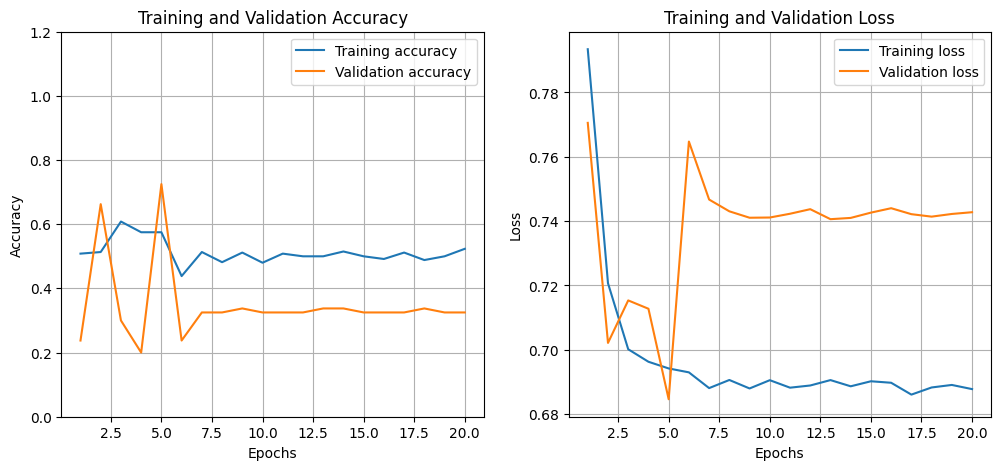

In [129]:
train_loss = init_history.history['loss']
val_loss = init_history.history['val_loss']
train_accuracy = init_history.history['accuracy']
val_accuracy = init_history.history['val_accuracy']
epochs = range(1, len(train_loss) + 1)

# Accuracy plots
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_accuracy, label='Training accuracy')
plt.plot(epochs, val_accuracy, label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0, 1.2)  # Set y-axis limits between 0 and 1
plt.grid(True)
plt.legend()

# Loss plots
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.show()

### Evaluation

In [130]:
test_loss, test_accuracy = init_model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

2/2 [==============================] - 2s 116ms/step - loss: 0.6959 - accuracy: 0.6102
Test Loss: 0.6959
Test Accuracy: 0.6102


In [134]:
threshold = 0.3
y_pred = (init_model.predict(X_test) > threshold).astype("int32")

# Flatten y_test and y_pred
y_test_flat = y_test.flatten()
y_pred_flat = y_pred[:, 0]

# Print classification report and confusion matrix
print("Classification Report:\n", classification_report(y_test_flat, y_pred_flat))
print("Confusion Matrix:\n", confusion_matrix(y_test_flat, y_pred_flat))

2/2 [==============================] - 0s 126ms/step
Classification Report:
               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        23
         1.0       0.61      1.00      0.76        36

    accuracy                           0.61        59
   macro avg       0.31      0.50      0.38        59
weighted avg       0.37      0.61      0.46        59

Confusion Matrix:
 [[ 0 23]
 [ 0 36]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


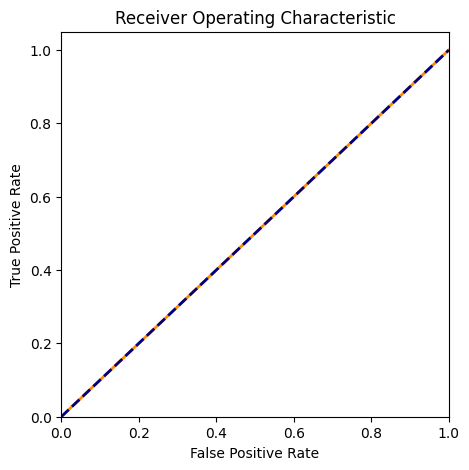

AUC: 0.5000


In [135]:
fpr, tpr, thresholds = roc_curve(y_test_flat, y_pred_flat)

# Plot ROC curve
plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.show()

# Calculate AUC
auc = roc_auc_score(y_test_flat, y_pred_flat)
print(f"AUC: {auc:.4f}")

## Conclusion

* ...

## Refernces

* https://medium.com/smileinnovation/how-to-work-with-time-distributed-data-in-a-neural-network-b8b39aa4ce00

* https://medium.com/smileinnovation/training-neural-network-with-image-sequence-an-example-with-video-as-input-c3407f7a0b0f

* https://keras.io/examples/vision/conv_lstm/#data-visualization